## Importing relevant libraries

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
from scipy.stats import unitary_group
from scipy.stats import moment
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from scipy.linalg import norm
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from qiskit import *
from qiskit import execute
from qiskit import transpiler
from qiskit import QuantumCircuit
from qiskit.circuit.add_control import add_control
from qiskit.extensions import UnitaryGate
from qiskit.circuit.reset import Reset
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.library.standard_gates import IGate, UGate, U3Gate
from qiskit.dagcircuit import DAGOpNode, DAGInNode
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
from qiskit.transpiler.passes.optimization import Optimize1qGates
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.exceptions import TranspilerError
from math import fsum
from scipy.optimize import minimize
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.providers.models import BackendConfiguration
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler.passes import BasisTranslator
from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.circuit import Delay
from qiskit.circuit.library import XGate, YGate, ZGate, RXGate, RYGate, RZGate
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer import AerSimulator

# Import Paddle libraries
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

# Libraries for implementing the VQD algorithm
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.primitives import Sampler, Estimator
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, TwoLocal, EfficientSU2
from qiskit.algorithms.optimizers import *
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.algorithms.eigensolvers import EigensolverResult, VQD

# Import classical optimizers
from qiskit_algorithms.optimizers import SPSA, P_BFGS, COBYLA

# Import Statevector and SparsePauliOp
from qiskit.quantum_info import SparsePauliOp, Statevector

# Import a fake backend and Qiskit simulators and/or noise libraries
from qiskit.providers.fake_provider import FakeMontreal
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator as AerEstimator 
from qiskit_aer.noise import NoiseModel

C:\Users\abc\anaconda3\lib\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\abc\anaconda3\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
C:\Users\abc\anaconda3\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: ht

## Function to generate the Schlogl operator matrix

In [2]:
def TridiagA(lambda_func, mu_func, N):
    """
    Creates tridiagonal stochastic matrix for the Schlogl model
    Inputs lambda and mu model functions, and N desired size of matrix
    Returns stochastic matrix (non-hermitian)
    """
    # initialize diagonals
    d1 = np.zeros(N - 1)
    d2 = np.zeros(N)
    d3 = np.zeros(N - 1)

    # element 1,1
    d2[0] = -lambda_func(0)

    # element N,N
    d2[N - 1] = -mu_func(N - 1)

    # bottom diagonal elements
    for i in range(N - 1):
        d1[i] = lambda_func(i)

    # top diagonal elements
    for i in range(1, N):
        d3[i - 1] = mu_func(i)

    # main diagonal elements
    for i in range(1, N - 1):
        d2[i] = -lambda_func(i) - mu_func(i)

    # putting the diagonals together
    Q = np.diag(d1, k = -1) + np.diag(d2, k = 0) + np.diag(d3, k = 1)
    
    return Q

def get_volume_array(start_V, stop_V, n_operator_qubits):
    # Function to generate the initial volume array (to carry out computations)
    
    num_elements = 2 ** n_operator_qubits
    step_size = (stop_V - start_V)/(num_elements - 1)
    
    # Generate the volume array, given that the step size has been determined
    volume_array = np.arange(start_V, stop_V, step_size)
    
    return volume_array

def get_unitary(matrix, add_half = False):
    """
    Purpose: given a matrix, returns the unitary, hermitian matrix to be diagonalized
    Input: matrix -> the matrix to be diagonalized
    Output: U -> the unitary matrix
            nqubits -> the number of qubis needed to represent the basis of U
            dimension -> the dimension of the original matrix
    """
    assert matrix.ndim == 2, "Error: Only a matrix maybe processed"
    assert matrix.shape[0] == matrix.shape[1], "Error: Only a square matrix maybe processed"

    if np.any(np.transpose(matrix) != matrix):
        matrix_T = np.transpose(matrix)
        matrix = np.dot(matrix_T, matrix)

    ## Finding the dimension of the matrix
    dimension_hermitian = matrix.shape[0]

    ## Finding the number of qubits required to represent the matrix
    nqubits = int(np.ceil(np.log2(dimension_hermitian)))

    ## Construct the relevant matrix
    op_dim = 2 ** nqubits
    op = np.eye(op_dim)
    op[0:dimension_hermitian, 0:dimension_hermitian] = np.copy(matrix)

    if add_half:
        op = op + np.pi * np.eye(op.shape[0])

    U = la.expm(1j*op)
    
    # Get the dimensions of the unitary matrix
    dimension = U.shape[0]

    return U, nqubits, dimension

def find_probability(eigenvector_raw):
    """
    Purpose: Find the probability associated with each basis of an eigenvector
    Input: eigenvector_raw -> Numpy array documenting the number of times each basis is detected within the eigenvector
    Output: eigenvector_prob -> Numpy array documenting the probability of detecting each basis
    """
    count_total = np.sum(eigenvector_raw)
    eigenvector_prob = eigenvector_raw / count_total
    
    return eigenvector_prob

def find_amplitude(eigenvector_prob):
    """
    Purpose: Finding the probability amplitude of each basis using quantum mechanics
    Input: eigenvector_prob -> Numpy array documenting the probability that each basis is measured
    Output: eigenvector -> Numpy array representing the eigenvector
    """
    eigenvector = np.sqrt(eigenvector_prob)
    return eigenvector

def normalize_eigenvector(vector):
    """
    Purpose: Normalizes a vector such that its norm is 1
    Input: vector -> The vector to be normalized
    Output: vector -> The normalized vector
    """
    L2 = np.sum(np.square(vector))
    vector = vector / np.sqrt(L2)

    return vector

## Classical analysis

### Defining model parameters and constructing the Schlogl operator

In [11]:
## Computing the block diagonal representation of the Schlogl operator matrix
# Defining parameters
a = 1
b = 1
k1 = 3
k2 = 0.6
k3 = 0.25
k4 = 2.95

# Number of qubits
num_operator_qubits = 3

# Matrix dimensions
N = 2 ** num_operator_qubits

# Generating the basis size array
x_axis = []

for i in range(2 ** num_operator_qubits):
    x_axis.append(i)

# Constructing the Schlogl operator for V = 1.1
# Get the volume array
start_V = 0.1
stop_V = 1.6
volume_array = get_volume_array(start_V, stop_V, 2)

# # For system volume V = 1.1
# volume_array = np.arange(0.1, 10.6, 0.1)

# Construct the matrix representation of the operator
for i, V in enumerate(volume_array):
    
    # Birth and death rates
    lambda_fn = lambda n: ((a*k1*n*(n-1))/V + b*k3*V)
    mu_fn = lambda n: ((k2*n*(n-1)*(n-2))/V**2 + n*k4)

    # stochastic matrix Q of dimension N x N
    Q = TridiagA(lambda_fn, mu_fn, N)
    
    i += 1
######################################################################    
    
# Compute the Hermitian form of the matrix
hermitian_matrix = np.dot(Q.T, Q)

# Print the volume array
print('The volume array is:')
print(volume_array)
print()

# Print the volume parameter for which the simulations are being run
print('The volume parameter is:')
print(volume_array[-1])
print()

# Print the Hermitian matrix (block diagonal form)
print('The Hermitian form of the Schlogl matrix is:')
print(hermitian_matrix)
print()

# Generate the unitary matrix
add_half = False
U, n_query_qubits, dimension = get_unitary(hermitian_matrix, add_half = add_half)

# Print the unitary matrix
print('The unitary matrix is:')
print(U)
print()

The volume array is:
[0.1 0.6 1.1]

The volume parameter is:
1.1

The Hermitian form of the Schlogl matrix is:
[[ 1.51250000e-01 -1.69812500e+00  1.62250000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.69812500e+00  1.91787500e+01 -2.22256250e+01  3.25193182e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.62250000e+00 -2.22256250e+01  2.02884019e+02 -3.00606660e+02
   1.35794962e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.25193182e+00 -3.00606660e+02  1.22687009e+03
  -1.61807885e+03  7.40453696e+02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.35794962e+02 -1.61807885e+03
   4.86612064e+03 -5.80127398e+03  2.54791183e+03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.40453696e+02
  -5.80127398e+03  1.48506792e+04 -1.64008602e+04  6.84061864e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.54791183e+03 -1.6400

### Exact diagonalization of the unitary matrix

In [12]:
A, P = la.eig(U)

A_real = np.real(A)
index = np.where(A_real == np.amax(A_real))[0][0]

eigenvalue = A[index]
zeromode_classic = P[:, index]

zeromode_classic = np.real(normalize_eigenvector(zeromode_classic))
zeromode_classic = np.reshape(zeromode_classic, (zeromode_classic.size, 1))

print("the available eigenvalues are: \n" + str(A))
print()

print("The minimum eigenvalue located is: \n" + str(eigenvalue))
print()

print("The minimum zeromode located is: \n" + str(np.real(zeromode_classic)))

the available eigenvalues are: 
[ 1.        -4.44089210e-16j -0.20822806-9.78080300e-01j
 -0.9560784 +2.93111044e-01j -0.80768129+5.89619317e-01j
 -0.01657371+9.99862647e-01j  0.46697248-8.84271848e-01j
  0.27493066-9.61464057e-01j -0.72038057+6.93579001e-01j]

The minimum eigenvalue located is: 
(0.9999999999964186-4.440892098500626e-16j)

The minimum zeromode located is: 
[[9.95669495e-01]
 [9.28166478e-02]
 [4.32619969e-03]
 [2.09612894e-03]
 [1.47154055e-03]
 [1.09127928e-03]
 [7.74886321e-04]
 [5.09791201e-04]]


## Quantum (VQD) analysis

### Initialization of callback helper functions (to store intermediate results)

In [6]:
# Initialization of arrays for storing intermediate VQD results
counts_noisy, values_noisy, steps_noisy = [], [], []
counts_noiseless, values_noiseless, steps_noiseless = [], [], []

def callback_BFGS(eval_count, params, value, meta, step):
    # Function to store intermediate values from VQD (noisy simulation)
    
    counts_noisy.append(eval_count)
    values_noisy.append(value)
    steps_noisy.append(step)
    
def callback_noiseless(eval_count, params, value, meta, step):
    # Function to store intermediate values from VQD (noisy simulation)
    
    counts_noiseless.append(eval_count)
    values_noiseless.append(value)
    steps_noiseless.append(step)

### Running VQD

In [7]:
def run_VQD(matrix, k, noise = True):
    # Function to implement the VQD algorithm
    
    dimension = matrix.shape[0]
    num_qubits = int(np.log2(dimension))
    
    # Define the qubit Hamiltonian
    qub_hamiltonian = SparsePauliOp.from_operator(matrix)
    
    # Define the circuit ansatz
    ansatz = RealAmplitudes(num_qubits = num_qubits, reps = 4)
    
    # Initialize the optimizer and the initial point
    initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
    
    # Initializing the estimator, sampler, and fidelity
    estimator = Estimator()
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    
    # Get the classical optimizer
    optimizer = P_BFGS(maxfun = 1000)
    
    # Run the VQD simulation 
    if not noise: # if False, run a noiseless simulation
        vqd = VQD(estimator = estimator, fidelity = fidelity, ansatz = ansatz, optimizer = optimizer, \
                  k = k, initial_point = initial_point, callback = callback_noiseless)
        result = vqd.compute_eigenvalues(operator = qub_hamiltonian)
        
        # Get the corresponding zeromode
        optimal_params = result.optimal_points
        zeromode_points = optimal_params[0]
        final_circuit = ansatz.assign_parameters(zeromode_points)
        zeromode_vqd = Statevector.from_instruction(final_circuit)
        
    else: # if True, run a noisy simulation
        # Get the backend
        backend = FakeMontreal()
        
        # Get the noise characteristics
        noise_model = NoiseModel.from_backend(backend) # get the noise model
        coupling_map = backend.configuration().coupling_map # get the coupling map
        basis_gates = noise_model.basis_gates # get the basis gates
        
        # Initialize the noisy estimator for VQD
        noisy_estimator = AerEstimator(
        backend_options = {
            "coupling_map": coupling_map,
            "noise_model": noise_model,
            "basis_gates": basis_gates,
        },
        run_options = {"seed": 1, "shots": 3000},
        transpile_options = {"seed_transpiler": 1},
    )
        # Run the VQD algorithm
        vqd = VQD(estimator = noisy_estimator, fidelity = fidelity, ansatz = ansatz, optimizer = optimizer, \
                  k = k, initial_point = initial_point, callback = callback_noisy)
        result = vqd.compute_eigenvalues(operator = qub_hamiltonian)
        
        # Get the corresponding zeromode
        optimal_params = result.optimal_points
        zeromode_points = optimal_params[0]
        final_circuit = ansatz.assign_parameters(zeromode_points)
        zeromode_vqd = Statevector.from_instruction(final_circuit)
        
    return result.eigenvalues, optimal_params, zeromode_vqd

### Running VQD on the Hermitian Schlogl matrix

In [13]:
eigenvalues, optimal_params, zeromode_vqd = run_VQD(matrix = hermitian_matrix, k = 2, noise = False)

## Printing relevant results
# Print the eigenvalues
print('The eigenvalues obtained using VQD are:')
print(eigenvalues)
print()

# Print the optimal parameters
print('The optimal parameters of the variational ansatz for eigenvalue computations are:')
print(optimal_params)
print()

# Print the zeromode obtained
print('The zeromode obtained using the VQD algorithm is:')
print(zeromode_vqd)
print()

INFO 2024-06-20 12:25:10,759 vqd.py:246] beta autoevaluated to 953218.4206120654
WARNING 2024-06-20 12:25:10,760 p_bfgs.py:124] For Windows, using only current process. Multiple core use not supported.
INFO 2024-06-20 12:25:19,254 vqd.py:317] Ground state optimization complete in 8.495309829711914 seconds.
Found opt_params [[-2.9303228  -2.93104125  3.04752275  3.09268958  3.14159265 -2.31372774
  -0.87942096  2.30272543  0.2913131   0.72077702 -1.26392674  1.72020822
   0.8121474   0.45596731 -0.93596118]] in 1008 evals
WARNING 2024-06-20 12:25:19,264 p_bfgs.py:124] For Windows, using only current process. Multiple core use not supported.
INFO 2024-06-20 12:25:40,726 vqd.py:325] 1 excited state optimization complete in 21.462287187576294 s.
Found opt_params [[-2.9303228  -2.93104125  3.04752275  3.09268958  3.14159265 -2.31372774
  -0.87942096  2.30272543  0.2913131   0.72077702 -1.26392674  1.72020822
   0.8121474   0.45596731 -0.93596118]
 [-3.14159265  2.02844561  3.09815027  2.782

The eigenvalues obtained using VQD are:
[0.05794323+0.j 7.00537086+0.j]

The optimal parameters of the variational ansatz for eigenvalue computations are:
[[-2.9303228  -2.93104125  3.04752275  3.09268958  3.14159265 -2.31372774
  -0.87942096  2.30272543  0.2913131   0.72077702 -1.26392674  1.72020822
   0.8121474   0.45596731 -0.93596118]
 [-3.14159265  2.02844561  3.09815027  2.78251179 -2.52331911 -2.81744302
  -2.23273349  2.73685406  2.30608244 -2.83724581  2.48044478  2.30674552
   1.2213139   2.69114723 -3.14159265]]

The zeromode obtained using the VQD algorithm is:
Statevector([-0.99505124+0.j, -0.04863174+0.j,  0.03864734+0.j,
              0.04197555+0.j,  0.04136649+0.j,  0.0369267 +0.j,
              0.02844736+0.j,  0.01919364+0.j],
            dims=(2, 2, 2))



### Generating zeromode (non-equilibrium steady-state) plots

In [9]:
def generate_plots(x_axis, zeromode_classic, zeromode_vqd):
    
    # Flatten lists
    zeromode_classic = [item for sublist in zeromode_classic for item in sublist]
    
    # Convert all (extraneous) negative values to positive values (as these are PDFs)
    zeromode_classic = [np.abs(value) for value in zeromode_classic]
    zeromode_vqd = [np.abs(value) for value in zeromode_vqd]
    
    # Main plot
    fig, ax = plt.subplots(dpi = 600)
    ax.plot(x_axis, zeromode_classic, "o-.", label = 'Exact diagonalization', markersize = 1)
    ax.plot(x_axis, zeromode_vqd, "^--", label = 'VQD')
    ax.set_xlabel('Basis size', fontsize = 17)
    ax.set_ylabel('PDF', fontsize = 17)
    ax.set_yscale('log')
    ax.grid(True)
    leg = ax.legend(frameon = True)
    leg.get_frame().set_edgecolor('k')
    
    # Error plot
    log_classic = [np.log(value) for value in zeromode_classic]
    log_quantum = [np.log(value) for value in zeromode_vqd]
    err_plot = [np.abs(log_classic[i] - log_quantum[i]) for i in range(len(log_classic))]

    # Inset plot
    inset_ax = inset_axes(ax, width = "30%", height = "20%", loc = 'lower left', \
                          bbox_to_anchor = (0.2, 0.1, 1, 1), bbox_transform = ax.transAxes)
    inset_ax.plot(x_axis, err_plot, '^--')
    inset_ax.set_xlabel("Basis size", fontsize = 10)
    inset_ax.set_ylabel("$|P_{\mathrm{classical}} - P_{\mathrm{quantum}}|$", fontsize = 10)
    inset_ax.grid(True)  # Enable grid lines on the inset plot
    
    plt.show()

<>:31: DeprecationWarning: invalid escape sequence '\m'
<>:31: DeprecationWarning: invalid escape sequence '\m'
C:\Users\abc\AppData\Local\Temp\ipykernel_16048\442977575.py:31: DeprecationWarning: invalid escape sequence '\m'
  inset_ax.set_ylabel("$|P_{\mathrm{classical}} - P_{\mathrm{quantum}}|$", fontsize = 10)


### Visualization

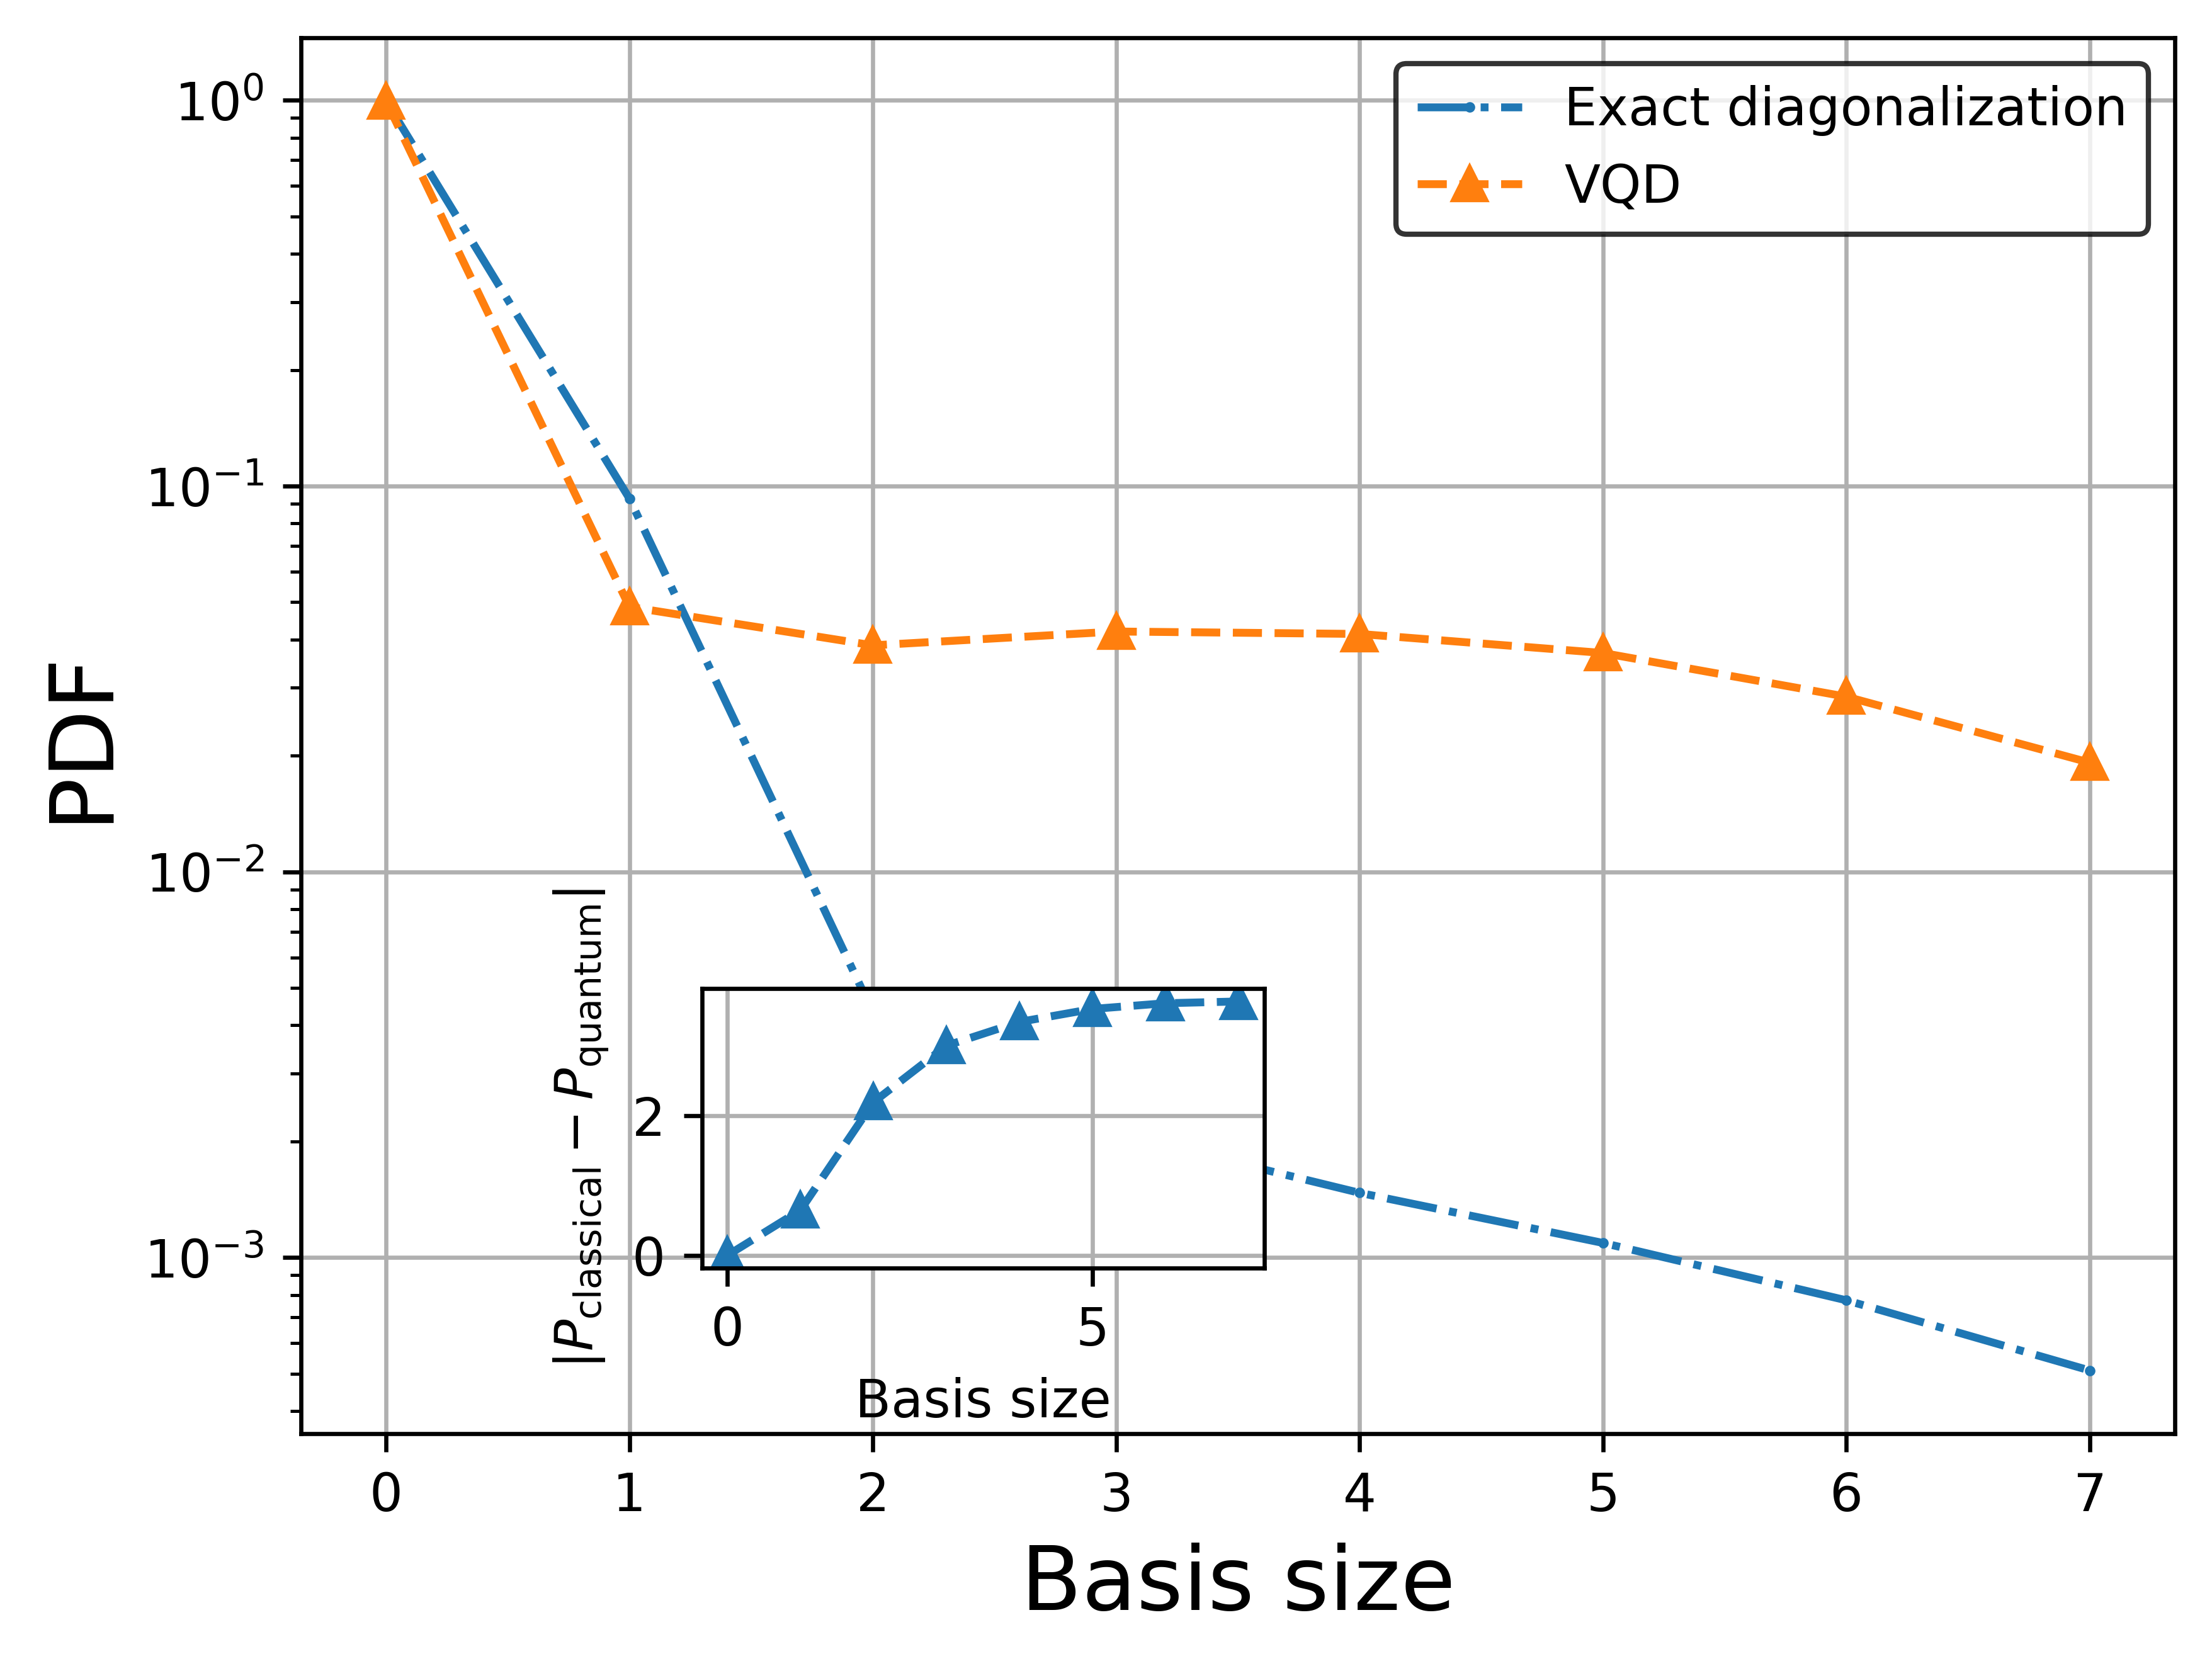

In [14]:
# Generate comparison and error plots
generate_plots(x_axis, zeromode_classic, -zeromode_vqd)